<a href="https://colab.research.google.com/github/ibrahim10sy/learn-python/blob/main/classification_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


La classification multi-classes à l'aide des stratégies One-vs-All (OvA) et One-vs-One (OvO).
---



In [ ]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install seaborn==0.13.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Visualisez la distribution de la variable cible pour comprendre l’équilibre des classes.

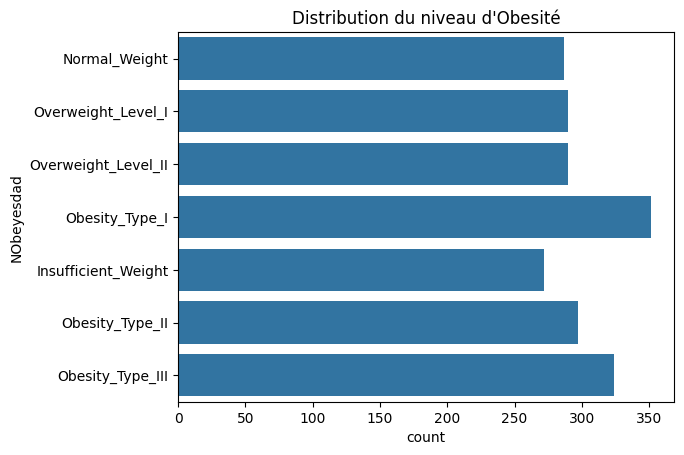

In [3]:
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution du niveau d\'Obesité')
plt.show()

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


Vérification des valeurs nulls

In [ ]:
data.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


Prétraitement des données


Mettons à l'échelle les caractéristiques numériques pour standardiser leurs plages et améliorer les performances du modèle.

In [5]:
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

In [8]:
continuous_columns

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Converture en DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

In [7]:
scaled_df

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625
...,...,...,...,...,...,...,...,...
2106,-0.525774,0.097045,1.711763,1.088342,0.404153,-0.456705,0.783135,0.407996
2107,-0.367195,0.502844,1.800914,1.088342,0.404153,-0.004702,0.389341,-0.096251
2108,-0.281909,0.541672,1.798868,1.088342,0.404153,0.075361,0.474971,-0.019018
2109,0.007776,0.404927,1.785780,1.088342,0.404153,1.377801,0.151471,-0.117991


Cancatené avec le data

In [9]:

scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

In [10]:
scaled_data

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III,-0.525774,0.097045,1.711763,1.088342,0.404153,-0.456705,0.783135,0.407996
2107,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III,-0.367195,0.502844,1.800914,1.088342,0.404153,-0.004702,0.389341,-0.096251
2108,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III,-0.281909,0.541672,1.798868,1.088342,0.404153,0.075361,0.474971,-0.019018
2109,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III,0.007776,0.404927,1.785780,1.088342,0.404153,1.377801,0.151471,-0.117991


La standardisation des données est importante pour mieux définir les limites de décision entre les classes en garantissant que les variations des caractéristiques se situent à des échelles similaires.

### Encodage one-hot
Convertissez les variables catégorielles au format numérique à l'aide de l'encodage one-hot.

In [11]:
data.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


In [12]:
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude target column

# Application de l'encodage one-hot
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

In [13]:
categorical_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [14]:
encoded_features

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.]])

In [15]:
encoder.get_feature_names_out(categorical_columns)

array(['Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes',
       'SCC_yes', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'], dtype=object)

In [16]:
# Convertion en DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combiné avec le dataset original
prep_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

In [17]:
prep_data

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Obesity_Type_III,-0.525774,0.097045,1.711763,1.088342,0.404153,-0.456705,0.783135,0.407996,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2107,Obesity_Type_III,-0.367195,0.502844,1.800914,1.088342,0.404153,-0.004702,0.389341,-0.096251,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2108,Obesity_Type_III,-0.281909,0.541672,1.798868,1.088342,0.404153,0.075361,0.474971,-0.019018,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2109,Obesity_Type_III,0.007776,0.404927,1.785780,1.088342,0.404153,1.377801,0.151471,-0.117991,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [18]:
prep_data.columns

Index(['NObeyesdad', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF',
       'TUE', 'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike',
       'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

Toutes les variables catégorielles ont été modifiées pour devenir des caractéristiques codées à chaud. Le nombre total de champs est ainsi porté à 24.

# Encoder la variable cible

In [19]:
prep_data['NObeyesdad'] = prep_data['NObeyesdad'].astype('category').cat.codes
prep_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Séparer les données d'entrée et les données cibles

In [20]:
X = prep_data.drop('NObeyesdad', axis=1)
y = prep_data['NObeyesdad']

In [21]:
X

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,-0.525774,0.097045,1.711763,1.088342,0.404153,-0.456705,0.783135,0.407996,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2107,-0.367195,0.502844,1.800914,1.088342,0.404153,-0.004702,0.389341,-0.096251,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2108,-0.281909,0.541672,1.798868,1.088342,0.404153,0.075361,0.474971,-0.019018,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2109,0.007776,0.404927,1.785780,1.088342,0.404153,1.377801,0.151471,-0.117991,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y

,NObeyesdad
0,1
1,1
2,1
3,5
4,6
...,...
2106,4
2107,4
2108,4
2109,4


# **Entraînement** et évaluation du modèle

Diviser l'ensemble de données
Divisez les données en sous-ensembles d'entraînement et de test.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Entraînez un modèle de régression logistique en utilisant la stratégie One-vs-All et évaluez ses performances.

In [32]:
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

Vous pouvez désormais évaluer la précision du modèle formé en tant que mesure de ses performances sur des données de test invisibles.

In [33]:
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 76.12%


In [34]:
for test_size in [0.1,0.3,0.2]:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
  model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
  model_ova.fit(X_train, y_train)
  y_pred_ova = model_ova.predict(X_test)
  # Evaluation metrics for OvA
  print("One-vs-All (OvA) Strategy")
  print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 75.94%
One-vs-All (OvA) Strategy
Accuracy: 74.92%
One-vs-All (OvA) Strategy
Accuracy: 76.12%


In [38]:
model_ova.coef_

array([[-5.32857309e-01,  2.13242083e+00, -8.16366657e+00,
         3.22105759e-01,  1.06603962e-01,  2.07378505e-01,
        -8.27843283e-02,  1.31655111e-01, -5.13388645e-01,
        -1.68411932e-01, -2.91422788e-01,  1.19845514e+00,
         7.14810701e-01,  3.48022195e-01, -7.47751970e-01,
        -2.69459556e-01, -4.18174717e-01,  2.21184193e-01,
         1.98027526e-01, -7.46571358e-01, -2.30398838e-01,
         1.15351158e-01, -5.07643251e-01],
       [-1.97205885e-01, -6.81339397e-02, -1.56892303e+00,
        -1.66285548e-01, -4.75945995e-03, -2.57154384e-01,
         2.32062429e-01, -1.76495906e-01,  9.40909158e-01,
        -1.93080610e-01, -9.53641704e-02, -1.05851846e+00,
        -1.68704478e+00, -1.48981893e+00,  1.04049237e+00,
         1.60822585e-01,  5.99543270e-01, -5.71662478e-01,
        -4.98339252e-01,  1.08992371e+00,  1.06417514e+00,
        -3.04338622e-01,  1.42240239e+00],
       [-1.81982262e-01, -7.63411764e-01,  8.55631704e-01,
        -7.98272876e-01, -3.4

In [39]:
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0)

In [40]:
feature_importance

array([0.43536572, 0.96997815, 3.12290632, 0.54169269, 0.33644266,
       0.27723295, 0.32214293, 0.17323389, 1.94275558, 0.71031834,
       0.83388966, 0.714883  , 0.78697531, 0.69330422, 0.65018372,
       0.65477335, 0.46852049, 0.49959267, 0.4461748 , 0.47537496,
       0.39154325, 0.57350853, 0.46369207])

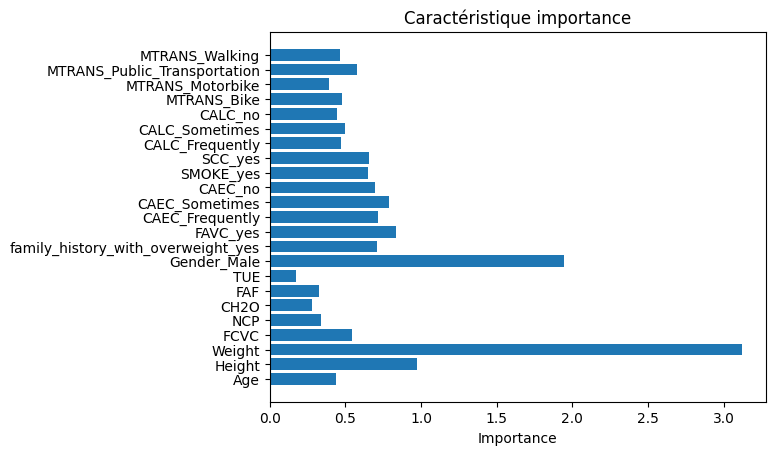

In [41]:
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0)
plt.barh(X.columns, feature_importance)
plt.title("Caractéristique importance")
plt.xlabel("Importance")
plt.show()

In [42]:
def obesity_risk_pipeline(data_path, test_size):
  file_path = data_path
  data = pd.read_csv(file_path)
  continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()
  categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
  categorical_columns.remove('NObeyesdad')  # Exclude target column

  # Application de l'encodage one-hot
  encoder = OneHotEncoder(sparse_output=False, drop='first')
  encoded_features = encoder.fit_transform(scaled_data[categorical_columns])
  # Convertion en DataFrame
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

  # Combiné avec le dataset original
  prep_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)
  prep_data['NObeyesdad'] = prep_data['NObeyesdad'].astype('category').cat.codes
  X = prep_data.drop('NObeyesdad', axis=1)
  y = prep_data['NObeyesdad']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
  model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
  model_ova.fit(X_train, y_train)
  y_pred_ova = model_ova.predict(X_test)

  # Evaluation metrics for OvA
  print("One-vs-All (OvA) Strategy")
  print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

In [49]:
obesity_risk_pipeline(file_path,0.5)

One-vs-All (OvA) Strategy
Accuracy: 77.18%
